This is a jupyter notebook to demonstrate the functionality of the heron-BBH binary black hole surrogate model.
The surrogate model is conditioned on numerical relativity data produced by the Georgia Tech group.

In [36]:
import heron
from heron import waveform
from george import kernels
import numpy as np

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/daniel/papers/thesis/thesis-style.mpl")

In [38]:
import elk.catalogue

In [39]:
total_mass = 60

In [40]:
catalogue = elk.catalogue.NRCatalogue(origin="SXS")

imr_cat = elk.catalogue.PPCatalogue("IMRPhenomPv2", 
                                    total_mass=total_mass, 
                                    fmin=95)
seo_cat = elk.catalogue.PPCatalogue("SEOBNRv4_ROM", 
                                    total_mass=total_mass, 
                                    fmin=95)

In [41]:
len(catalogue.waveforms)

764

/home/daniel/.virtualenvs/IGRlaptop21/heron-stable/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


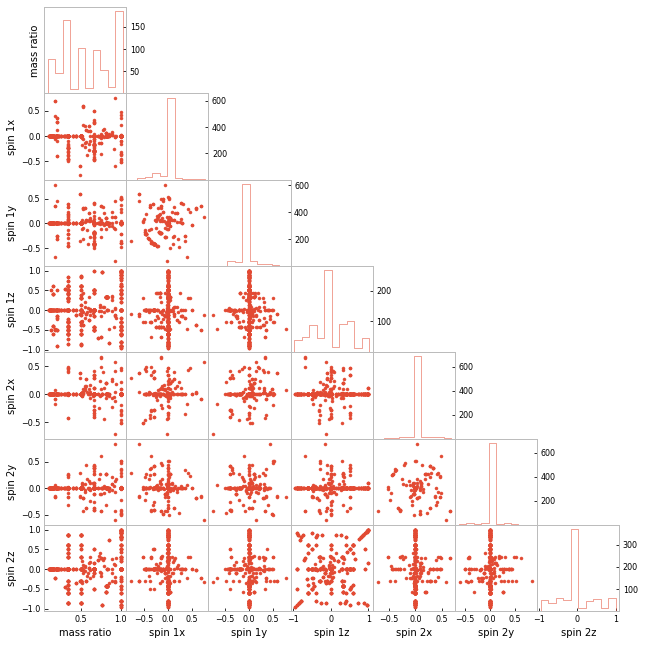

In [7]:
f = catalogue.coverage_plot()

In [8]:
f.savefig("coverage.pdf")

Define the Gaussian process model. There are separate kernel terms for the time axis, the mass axis, and each of the spin axes. These are all initialised with plausible length-scales.

This is used to build a `heron` Gaussian process 'catalogue', which is the interpolation object.

For this scenario the GPR is trained with waveforms sampled at 1,024-Hz, a minimum frequency of 95-Hz (which is chosen to allow all but one of the NR waveforms to be included in the training set), and a total CBC system mass of 60 solar masses.

A small quantity (with amplitude 1e-8) is added to the kernel to improve the numerical stability of the algorithm, and the HODLR matrix solver is used.

In [ ]:
problem_dims = 8
c_ind = catalogue.c_ind
time_covariance = kernels.RationalQuadraticKernel(.05, 400,
                                           ndim=problem_dims,
                                           axes=c_ind['time'],)
mass_covariance = kernels.ExpSquaredKernel(0.005, #0.09
#mass_covariance = kernels.Matern52Kernel(0.005, #0.09
                                           ndim=problem_dims,
                                           axes=c_ind['mass ratio'])
spin_covariance = kernels.ExpSquaredKernel([0.005, 0.005, 0.005, 
#spin_covariance = kernels.Matern52Kernel([0.005, 0.005, 0.005, 
                                            0.005, 0.005, 0.005], 
                                           ndim=problem_dims, 
                                           axes=[2,3,4,5,6,7])

covariance =  1e1 * mass_covariance * time_covariance * spin_covariance

gp = gp_cat = waveform.GPCatalogue(catalogue, covariance,
                                   total_mass=total_mass, fsample=1024,
                                   mean=0.0,
                                   ma=[(2,2)],
                                   solver="hodlr",
                                   white_noise=1e-6,
                                   fmin=95,)

There was an error producing a waveform for SXS_BBH_0079_Res5
There was an error producing a waveform for SXS_BBH_0057_Res4
There was an error producing a waveform for SXS_BBH_0010_Res1
There was an error producing a waveform for SXS_BBH_0128_Res5
There was an error producing a waveform for SXS_BBH_0054_Res5
There was an error producing a waveform for SXS_BBH_0142_Res5
There was an error producing a waveform for SXS_BBH_0179_Res4
There was an error producing a waveform for SXS_BBH_0271_Res4
There was an error producing a waveform for SXS_BBH_0630_Res3
There was an error producing a waveform for SXS_BBH_0234_Res4
There was an error producing a waveform for SXS_BBH_0321_Res1
There was an error producing a waveform for SXS_BBH_0321_Res3
There was an error producing a waveform for SXS_BBH_0237_Res5
There was an error producing a waveform for SXS_BBH_0627_Res1
There was an error producing a waveform for SXS_BBH_0308_Res5
There was an error producing a waveform for SXS_BBH_0020_Res4
There wa

There was an error producing a waveform for SXS_BBH_0282_Res4
There was an error producing a waveform for SXS_BBH_0272_Res3
There was an error producing a waveform for SXS_BBH_0033_Res5
There was an error producing a waveform for SXS_BBH_0320_Res1
There was an error producing a waveform for SXS_BBH_0234_Res3
There was an error producing a waveform for SXS_BBH_0138_Res5
There was an error producing a waveform for SXS_BBH_0131_Res5
There was an error producing a waveform for SXS_BBH_0042_Res4
There was an error producing a waveform for SXS_BBH_0050_Res5
There was an error producing a waveform for SXS_BBH_0113_Res5
There was an error producing a waveform for SXS_BBH_0076_Res5
There was an error producing a waveform for SXS_BBH_0121_Res5
There was an error producing a waveform for SXS_BBH_0261_Res3
There was an error producing a waveform for SXS_BBH_0111_Res5
There was an error producing a waveform for SXS_BBH_0303_Res4
There was an error producing a waveform for SXS_BBH_0180_Res2
There wa

With the GPR object created the trained values for the hyperparameters are set. These were determined after 2,000 iterations of ADAM-based training on a much more powerful machine.

In [9]:
# After 2000 training iterations with ADAM
gp_cat.gp.set_parameter_vector(np.log([1.96628473e+00,
                                       3.33975754e-04,
                                       1.64245209e+00, 3.29722921e+02,
                                       8.78725810e-04, 7.28872939e-04, 6.98418530e-04,
                                       8.91739716e-04, 7.28836193e-04, 7.05170046e-04]))

We define a function to produce inspection plots which naively compare samples from the GPR to two different waveform approximant models.

In [7]:
from matplotlib import rc, font_manager
lato = {'family': 'Lato',
        'color':  'black',
        'weight': 'light',
        'size': 10,
        }
ssp_ticks = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 6,
        }
ssp_legend = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 8,
        }
ticks_font = font_manager.FontProperties(**ssp_ticks)

In [29]:
def sample_plot(p, surrogates=["IMR", "SEO"], phase_shift=(0,0)):
    """
    Make a plot to compare sample draws from the GPR to SEOBNRv4 and 
    IMRPhenomPv2.
    """
    samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-400, 100, 1024], samples=100)
    
    if "IMR" in surrogates:
        imr = imr_cat.waveform(p=p,
                            time_range=[-400., 100., 1024],
                              coa_phase=phase_shift[0],
                              )
    if "SEO" in surrogates:
        seo = seo_cat.waveform(p=p,
                        time_range=[-400., 100., 1024],
                              coa_phase=phase_shift[1],)
        #seo[0].times -= seo[0].times[np.argmax(seo[0].data)]
    width = 4.5
    height = width/1.618
    f, ax = plt.subplots(1,1, figsize=(2*width, height), dpi=300);
    mean, var = gp_cat.waveform(p=p, time_range= [-400, 100, 1024])
    times = np.linspace(-400,100, 1024)
    times -= times[np.argmax(mean)]
    waveforms = []
    for sample in samples:
        sample.times -= sample.times[np.argmax(mean)]
        ax.plot(sample.times, sample.data/1e19, alpha=0.05, color='k');
        waveforms.append(sample.data)

    #mean = np.array(waveforms).mean(axis=0)
    
    ax.plot(times, mean/1e19, color="#7e25aa", label="GPR Mean")
        
    if "IMR" in surrogates:
        ax.plot(imr[0].times*1e4, imr[0].data, label="IMRPhenomPv2");
    if "SEO" in surrogates:
        ax.plot(seo[0].times*1e4, seo[0].data, label="SEOBNRv4");
        
    ax.set_xlabel("Times [msec] from merger", fontdict=lato);
    ax.set_ylabel("Strain (h+)", fontdict=lato);

     
    #ax.plot(imr[0].times*1e4, 1024*mean/1e16, color="#7e25aa", label="GPR Mean")
    
    ax.legend(prop=ssp_legend);
    
    return f, ax

In [9]:
query_table = catalogue.table.query( "spin_1x == 0 & spin_1y == 0 & spin_1z == 0"
            " & spin_2x == 0 & spin_2y == 0 & spin_2z == 0")
query_waveforms = [waveform for waveform in catalogue.waveforms if waveform.tag in list(query_table['tag'])]

In [19]:
gp_cat.gp.white_noise.value=1e-8

In [25]:
vector = """2.78313903e-02 2.12229543e-04 2.19031290e+00 2.68911359e+02
 1.15843470e-03 6.93304320e-04 5.60724777e-04 1.17640183e-03
 6.92831529e-04 3.78350668e-04"""
vector=vector.split(" ")
vector = map(float, vector)
# After 2000 training iterations with ADAM
gp_cat.gp.set_parameter_vector(np.log(vector))

In [ ]:
#gp_cat.optimise(max_iter=10)

In [19]:
# After 2000 training iterations with ADAM
gp_cat.gp.set_parameter_vector(np.log([1.96628473e-01,
                                       3.33975754e-04,
                                       1.64245209e+00, 3.29722921e+02,
                                       8.78725810e-04, 7.28872939e-04, 6.98418530e-04,
                                       8.91739716e-04, 7.28836193e-04, 7.05170046e-04]))

(-0.015, 0.01)

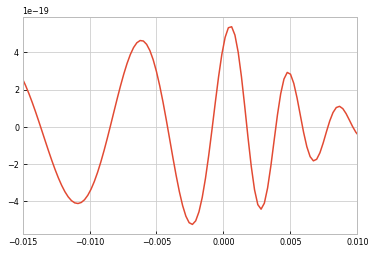

In [34]:
plt.plot(catalogue.waveforms[0].timeseries(total_mass=60)[0].times, catalogue.waveforms[0].timeseries(total_mass=60)[0].data)
plt.xlim(-0.015, 0.01)

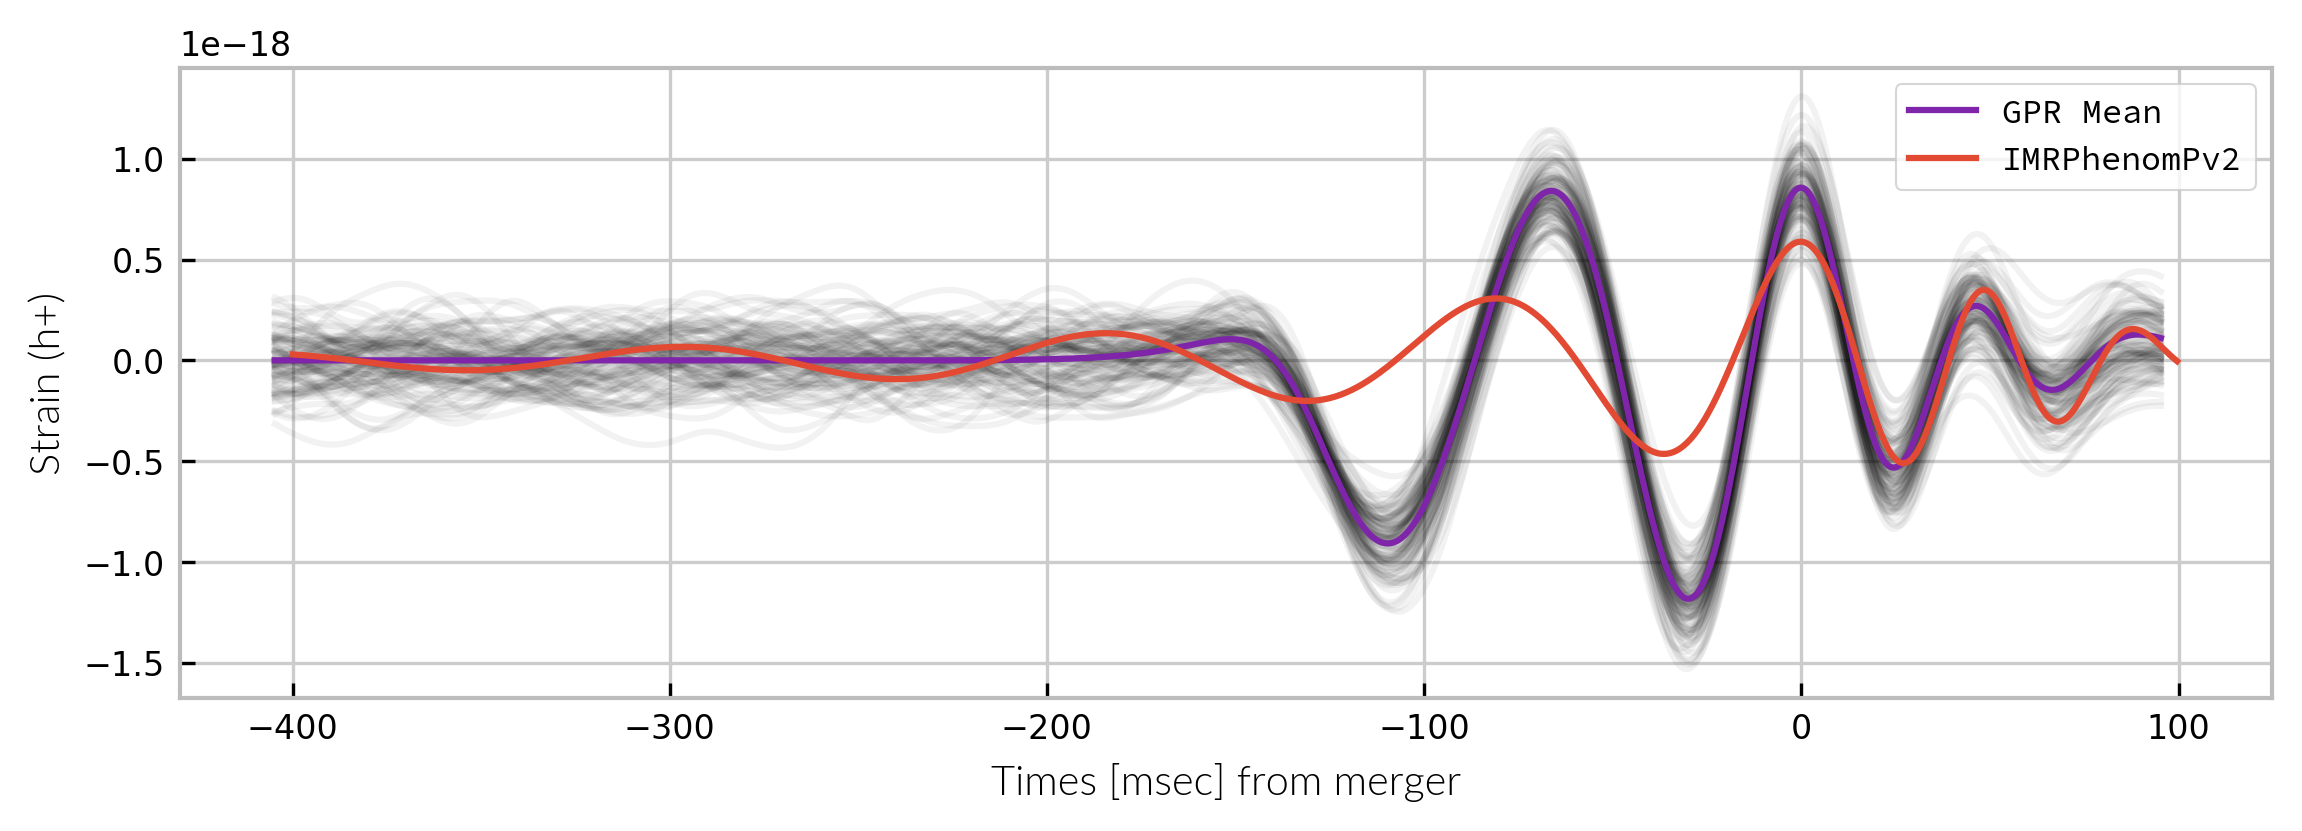

In [30]:
waveform = catalogue.waveforms[0]
sample_plot({"mass ratio": waveform.mass_ratio,
                "spin 1x": waveform.spin_1x, "spin 1y": waveform.spin_1y, "spin 1z": waveform.spin_1z,
                "spin 2x": waveform.spin_2x, "spin 2y": waveform.spin_2y, "spin 2z": waveform.spin_2z,},
            surrogates=["IMR"],
           phase_shift = (np.pi/2.,np.pi/2.)
           );
plt.plot(catalogue.waveforms[0].timeseries(total_mass=60)[0].times*1e4, catalogue.waveforms[0].timeseries(total_mass=60)[0].data)

#plt.plot(np.linspace(-150, 100, 1024), mean/1e19)

In [24]:
waveforms = []
variances = []
imr_match_phase = []
seo_match_phase = []
for mass_ratio in np.linspace(0.1,1,100):
    print("Mass ratio: {}".format(mass_ratio))
    p = {"mass ratio": mass_ratio,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0,}
    mean, var = gp_cat.waveform(p=p, time_range= [-150, 100, 1024])
    #times = np.linspace(-150,100, 1024)
    #times -= times[np.argmax(mean)]
    waveforms.append(mean)
    variances.append(var)
    ts_seo = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])
    ts_imr = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])
    matchimr, phase = optim_match(mean, ts_imr)
    imr_match_phase.append(phase[0])
    matchseo, phase = optim_match(mean, ts_seo)
    seo_match_phase.append(phase[0])

Mass ratio: 0.1


NameError: name 'partial' is not defined

In [ ]:
plt.imshow(np.array(waveforms), extent=[-150,100,0.1,1], aspect=10)

Mass ratio: 0.1
Mass ratio: 0.2
Mass ratio: 0.3
Mass ratio: 0.4
Mass ratio: 0.5
Mass ratio: 0.6
Mass ratio: 0.7
Mass ratio: 0.8
Mass ratio: 0.9
Mass ratio: 1.0


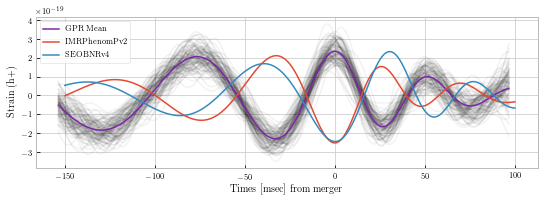

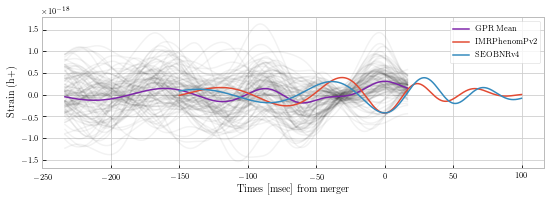

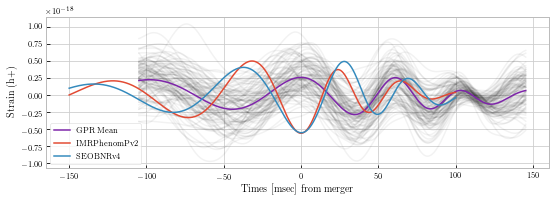

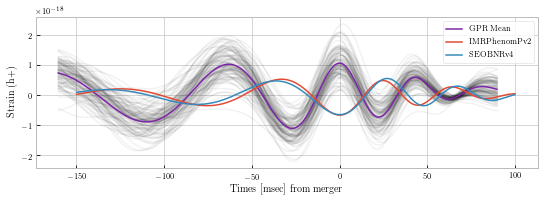

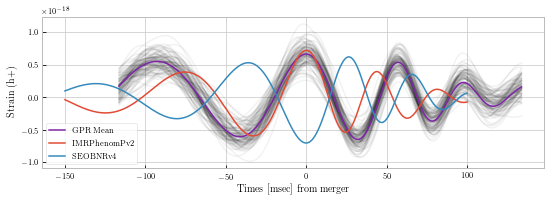

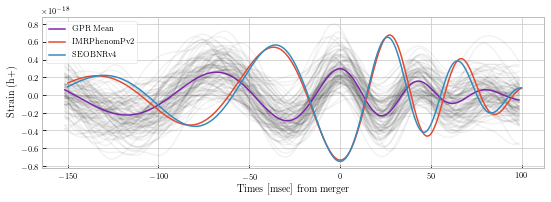

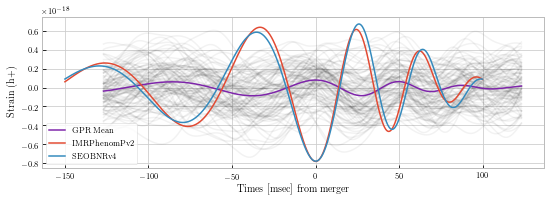

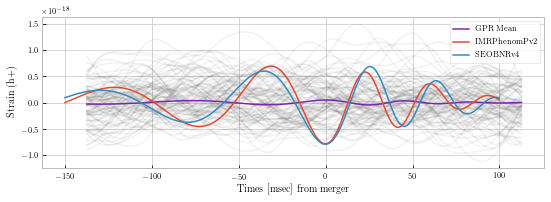

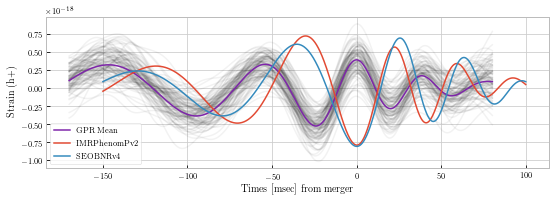

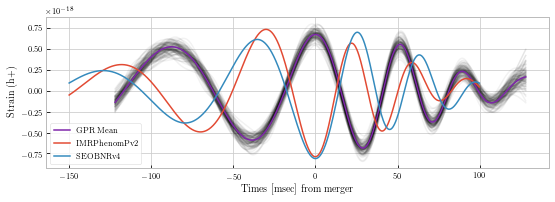

In [35]:
for mass_ratio in np.linspace(0.1,1,10):
    print("Mass ratio: {}".format(mass_ratio))
    sample_plot({"mass ratio": mass_ratio,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0,},)

## Anti-aligned spin waveform

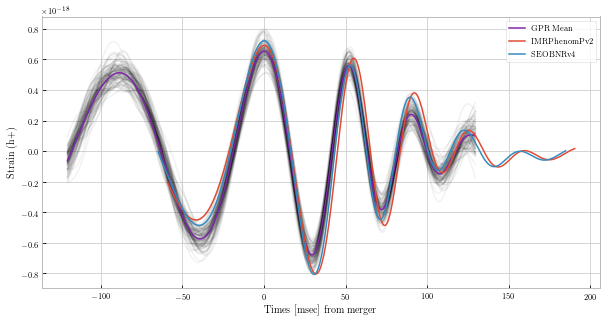

In [50]:
sample_plot({"mass ratio": 1,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0.6,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": -0.6,},
           phase_shift = (0.25, 2.40)
           );

## Aligned spin waveforms

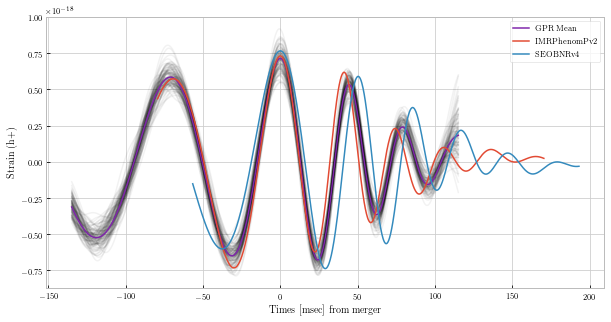

In [52]:
sample_plot({"mass ratio": 1,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0.3,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0.3,},
           phase_shift = (0.25, 2.40));

## Precessing waveforms

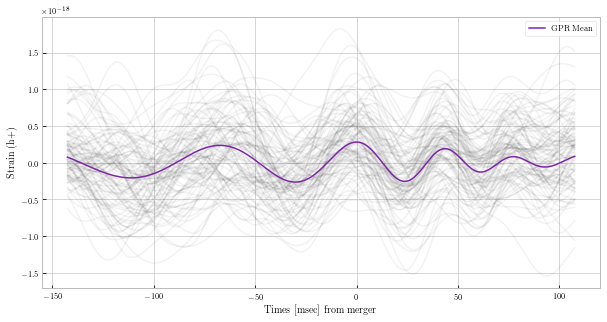

In [53]:
sample_plot({"mass ratio": 1,
                 "spin 1x": -0.15, "spin 1y": 0.4, "spin 1z": 0.4,
                 "spin 2x": -0.000, "spin 2y": -0.000, "spin 2z": 0.60,},
           surrogates=False,
           phase_shift = (0, 0.507));

## Looking at the match over a range of mass-ratios

In [193]:
optim_match(mean, ts_imr)

(0.9786842146909853, array([-0.45584527]))

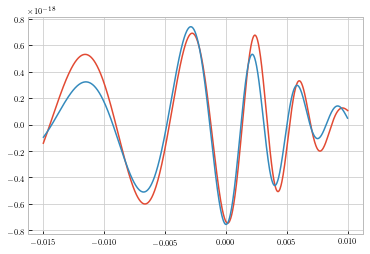

In [203]:
plt.plot(np.linspace(-0.015, 0.01, 1024), mean/1e19)
imr = ts_imr(coa_phase=-0.455)[0]
plt.plot(imr.times, imr.data)

In [199]:
ts_imr(coa_phase=-0.455)

(<elk.waveform.Timeseries at 0x7f4c12616e50>,
 <elk.waveform.Timeseries at 0x7f4c033f7cd0>)

TypeError: float() argument must be a string or a number

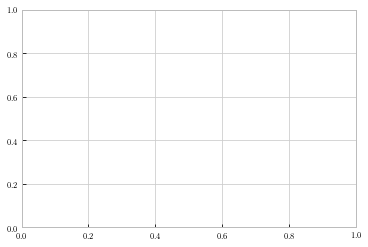

In [195]:
plt.plot(ts_imr)

In [59]:
max_phase_seo, max_match_seo = [], []
max_phase_imr, max_match_imr = [], []

for mass_ratio in np.linspace(0.1, 1.0, 45):
    print(mass_ratio)
    p = {"mass ratio": mass_ratio,
                     "spin 1x": 0, "spin 1y": 0., "spin 1z": 0.,
                     "spin 2x": 0, "spin 2y": 0., "spin 2z": 0.,}
    samples = gp_cat.waveform_samples(p=p,
                                      time_range=[-150, 100, 1024], samples=100)
    from functools import partial
    ts_seo = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])
    ts_imr = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])

    waveforms = []    

    mean, var =  gp_cat.waveform(p=p, time_range=[-150, 100, 1024])
    times = np.linspace(-150, 100, 1024)
    
    matches_seo = []
    matches_imr = []
    phases = np.linspace(0, np.pi*2, 100)
    for phase in phases:
        matches_seo.append(match(mean, ts_seo, phase=phase))
        matches_imr.append(match(mean, ts_imr, phase=phase))
    max_phase_seo.append(phases[np.argmax(matches_seo)])
    max_match_seo.append(np.max(matches_seo))
    max_phase_imr.append(phases[np.argmax(matches_imr)])
    max_match_imr.append(np.max(matches_imr))

0.1
0.12045454545454545
0.14090909090909093
0.16136363636363638
0.18181818181818182
0.20227272727272727
0.22272727272727272
0.2431818181818182
0.26363636363636367
0.28409090909090906
0.30454545454545456
0.325
0.34545454545454546
0.36590909090909096
0.38636363636363635


KeyboardInterrupt: 

In [103]:
data = np.array([np.linspace(0.1, 0.36590909090909096, len(max_match_seo)), max_phase_seo, max_match_seo, max_phase_imr, max_match_imr]).T

In [104]:
data

array([], shape=(0, 5), dtype=float64)

In [105]:
np.savetxt("match_data.txt", data)

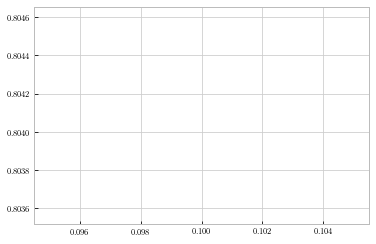

In [190]:
plt.plot(np.linspace(0.1, 0.36590909090909096, len(max_match_seo)), max_match_seo)
plt.plot(np.linspace(0.1, 0.36590909090909096, len(max_match_seo)), max_match_imr)
#plt.plot(max_match_imr)

In [41]:
matches = []
for phase in np.linspace(0, np.pi*2, 100):
    matches.append(match(mean, ts_seo, phase=phase))
matches = np.array(matches)

In [42]:
matches

array([0.81615228, 0.800092  , 0.78310027, 0.76522909, 0.74653111,
       0.73312087, 0.71291745, 0.97666647, 0.97680048, 0.97542806,
       0.97253701, 0.96811891, 0.96216916, 0.95468699, 0.94567558,
       0.94150816, 0.92996763, 0.91700273, 0.90952048, 0.89404068,
       0.88429337, 0.87336321, 0.8544741 , 0.84145547, 0.82736998,
       0.81226589, 0.79619313, 0.77920292, 0.76134742, 0.74881685,
       0.72936084, 0.70921413, 0.97603457, 0.97584533, 0.97416034,
       0.97096819, 0.96626123, 0.96003559, 0.95229124, 0.94303202,
       0.93871508, 0.92686537, 0.92017581, 0.90578618, 0.8968034 ,
       0.87994622, 0.86877002, 0.85645957, 0.83628703, 0.82197649,
       0.80665544, 0.7903741 , 0.77318395, 0.76142652, 0.74253143,
       0.72290233, 0.70836843, 0.97612673, 0.97556482, 0.97350396,
       0.96993368, 0.96484726, 0.9582418 , 0.95011822, 0.94048134,
       0.93589272, 0.92367028, 0.91671562, 0.9019612 , 0.89272239,
       0.87551125, 0.86409042, 0.85154231, 0.83791223, 0.82324

In [45]:
np.linspace(0, 2*np.pi, 100)[np.argmax(matches)], np.max(matches)

(0.5077321460347141, 0.9768004819836464)

In [ ]:
for sample in samples:
    waveforms.append(sample.data)

# SEO and IMR-based calculations
waveform_imr = ts_imr(coa_phase=2.919)[0]
#waveform_seo = ts_seo(coa_phase=0.507)[0]
                     
mean = np.array(waveforms).mean(axis=0)
#times = np.linspace(-150, 100, 1024)/1e4

mean_match_imr = match(mean/1e21, ts_imr)
#mean_match_seo = match(-mean/1e21, ts_seo)

imr_matches = []
seo_matches = []

for sample in samples:
    imr_matches.append(match(sample.data, ts_imr, phase=2.855))
    #seo_matches.append(match(-sample.data, ts_seo, phase=0.507))
                     

In [92]:
p = {"mass ratio": 1,
                 "spin 1x": -0.12, "spin 1y": 0.40, "spin 1z": 0.425,
                 "spin 2x": -0.001, "spin 2y": -0.004, "spin 2z": 0.60,}
samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 100, 1024], samples=100)

In [19]:
# Poor interpolation point
p = {"mass ratio": 1,
                 "spin 1x": -0.12, "spin 1y": 0.80, "spin 1z": 0.425,
                 "spin 2x": -0.001, "spin 2y": -0.004, "spin 2z": 0.60,}
samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 100, 1024], samples=100)

In [20]:
from functools import partial
#ts_seo = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])
ts_imr = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])

In [21]:
waveform_imr = ts_imr(coa_phase=2.919)[0]

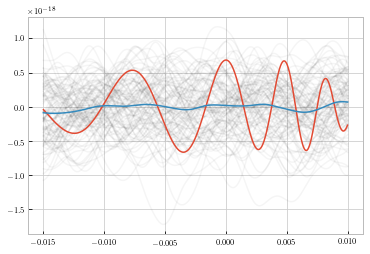

In [23]:
waveforms = []
for sample in samples:
    waveforms.append(sample.data)
    plt.plot(sample.times/1e4, sample.data/1e19, color='k', alpha=0.04)
plt.plot(waveform_imr.times, waveform_imr.data)
waveforms = np.array(waveforms)
plt.plot(sample.times/1e4, waveforms.mean(axis=0)/1e19)

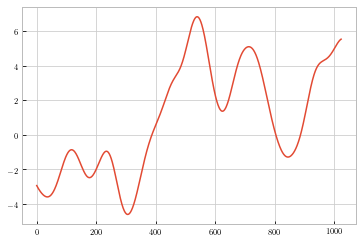

In [38]:
plt.plot(samples[50].data)

In [73]:
matches = []
waveforms = []    


for sample in samples:
    waveforms.append(sample.data)

# SEO and IMR-based calculations
waveform_imr = ts_imr(coa_phase=2.919)[0]
#waveform_seo = ts_seo(coa_phase=0.507)[0]
                     
mean = np.array(waveforms).mean(axis=0)
#times = np.linspace(-150, 100, 1024)/1e4

mean_match_imr = match(mean/1e21, ts_imr)
#mean_match_seo = match(-mean/1e21, ts_seo)

imr_matches = []
seo_matches = []

for sample in samples:
    imr_matches.append(match(sample.data, ts_imr, phase=2.855))
    seo_matches.append(match(-sample.data, ts_seo, phase=0.507))
                     


KeyboardInterrupt: 

In [124]:
from matplotlib.gridspec import GridSpec

In [125]:
width = 4.5
height = width/1.618

f = plt.figure(constrained_layout=True, figsize=(2 * width, height))#, dpi=500)

gs = GridSpec(1,4, figure = f)

# Waveform plot
times = samples[0].times/1e4 #np.linspace(-150, 100, 1024)/1e4
std = np.array(waveforms).std(axis=0)
ax_wave = f.add_subplot(gs[0:3])
ax_hist = f.add_subplot(gs[3])
for sample in samples[1:]:
    ax_wave.plot(sample.times/1e4, sample.data/1e19, color='k', alpha=0.0525, lw=0.5)
ax_wave.plot(samples[0].times/1e4, samples[0].data/1e19, color='k', alpha=0.0525, lw=0.5, label="GPR Draws")
ax_wave.plot(times, mean/1e19, label = "GPR Mean", 
             linestyle="--",
             alpha=0.5, color='k', lw=2)
ax_wave.fill_between(times, (mean+std**2)/1e19, (mean-std**2)/1e19, alpha=0.1, color='k', label="GPR Variance")
    
# SEOBNRv4
#ax_wave.plot(waveform_seo.times, -waveform_seo.data, label="SEOBNRv4", lw=2, alpha=0.8)
# IMRPhenomPv2
ax_wave.plot(waveform_imr.times, waveform_imr.data, label="IMRPhenomPv2", 
             lw=2, alpha=0.8, color="#348ABD")

ax_wave.legend()

times = samples[0].times/1e4 #np.linspace(-150, 100, 1024)/1e4

ax_wave.set_xlim([-0.015, 0.01])


#ax_hist.hist(1.0 - np.array(seo_matches), range=(0,.1), bins=11, 
#             density=True, histtype="stepfilled", alpha=0.4, label="SEOBNRv4")
ax_hist.hist(1.0 - np.array(imr_matches), 
             range=(0,1.0), 
             density=True,
             bins=21, 
             histtype="stepfilled", 
             alpha=0.4,
             color="#348ABD",
             label="IMRPhenomPv2"
            )
ax_hist.legend()
#ax_hist.vlines(x=[1-mean_match_imr, 1-mean_match_seo], ymax=35, ymin=0,
#              color=['blue', 'red'])

ax_wave.set_xlabel("Time since merger [s]")
ax_hist.set_xlabel("Mismatch")
ax_wave.set_ylabel("Strain")
#f.tight_layout()
#f.savefig("poor-fit.pdf")

NameError: name 'samples' is not defined

<Figure size 648x200.247 with 0 Axes>

In [78]:
from functools import partial
#ts_seo = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])
ts_imr = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])
#match(samples[0], )

matches_seo = []
matches_imr = []
for phase in np.linspace(0, 2*np.pi, 100):
    matches_seo.append(match(mean/1e19, ts_seo, phase=phase))
    matches_imr.append(match(mean/1e19, ts_imr, phase=phase))
matches_seo = np.array(matches_seo)
matches_imr = np.array(matches_imr)

In [79]:
print(np.linspace(0, 2*np.pi, 100)[matches_seo.argmax()])
print(np.linspace(0, 2*np.pi, 100)[matches_imr.argmax()])

0.5077321460347141
2.8559933214452666


In [91]:
print(np.linspace(0, 2*np.pi, 100)[matches.argmax()])

2.9194598396996057


In [88]:
p = {"mass ratio": 1,
                 "spin 1x": -0.12, "spin 1y": 0.40, "spin 1z": 0.425,
                 "spin 2x": -0.001, "spin 2y": -0.004, "spin 2z": 0.60,}

waveforms = []
for sample in samples:
    waveforms.append(sample.data)
    #plt.plot(sample.times/1e4, sample.data/1e19, color='k', alpha=0.04)
    
waveforms = np.array(waveforms)
#plt.plot(sample.times/1e4, waveforms.mean(axis=0)/1e19)

ts = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])
mean = waveforms.mean(axis=0)
matches = []
for phase in np.linspace(0, 2*np.pi, 100):
    matches.append(match(mean/1e19, ts, phase=phase))
matches = np.array(matches)

In [85]:
p = {"mass ratio": .1,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0,}
samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 100, 1024], samples=100)

In [25]:
ts = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])

In [26]:
matches = []
for sample in samples:
    matches.append(match(sample.data, ts, phase=1.90))

(array([16., 23., 18.,  9., 10.,  4.,  1.,  4.,  0.,  0.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

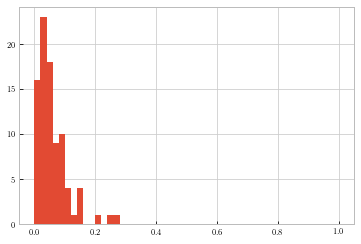

In [27]:
plt.hist(1-np.array(matches), bins=50, range=(0,1))

In [28]:
neg_match = lambda x: -match(samples[0].data/1e19, ts, phase=x)

In [29]:
match(samples[0].data/1e19, ts, phase=1.5)

0.9030291439690815

In [30]:
from scipy.optimize import basinhopping
basinhopping(neg_match, x0=1.9)

KeyboardInterrupt: 

In [ ]:
neg_match(3)

In [ ]:
imr = imr_cat.waveform(p=p, coa_phase=0,
                            time_range=[-150., 100., 1024])
imr_1 = imr_cat.waveform(p=p, coa_phase=1.9,
                            time_range=[-150., 100., 1024])
seo = seo_cat.waveform(p=p, coa_phase=1.6,
                            time_range=[-150., 100., 1024])
for sample in samples:
    plt.plot(sample.times/1e4, sample.data/1e19, alpha=0.05, color='k')

#plt.plot(imr[0].times, imr[0].data)
plt.plot(imr_1[0].times, imr_1[0].data)
plt.plot(seo[0].times, seo[0].data)


In [15]:
from matplotlib import rc, font_manager
lato = {'family': 'Lato',
        'color':  'black',
        'weight': 'light',
        'size': 10,
        }
source_code_pro = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 6,
        }
ticks_font = font_manager.FontProperties(**source_code_pro)

In [16]:
def plot_planes(ranges, fixed):
    """
    Produce a plot of the waveform predictions from
    the GP.

    Parameters
    ----------
    ranges : dict
       A dictionary in which the keys are the name of the parameter
       and the values are a list in the format [start, end, npoints]
       at which the GP should be evaluated for the plane.
    fixed : dict
       A dictionary in which the keys are the name of the parameter
       which should be fixed, and the value is the fixed value of 
       that parameter.
    """

    mean, var = gp_cat.mean(ranges, fixed)

    ranges_x = list(ranges.items())[0][1]
    ranges_y = list(ranges.items())[1][1]

    f, ax = plt.subplots(1,1, figsize=(6, 6/1.6), dpi=300)
    im = ax.imshow(mean/1e19, origin="lower", cmap = "magma",# vmin=-3, vmax=3,
                   extent = (ranges_x[0], ranges_x[1], ranges_y[0], ranges_y[1]),
                   aspect = ( (ranges_x[1] - ranges_x[0])
                              / (ranges_y[1] - ranges_y[0] )))
    cax = f.add_axes([0.9, 0.1, 0.02, 0.8])
    cax.yaxis.get_offset_text().set_fontproperties(ticks_font)
    f.colorbar(im, cax=cax, orientation='vertical')

    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    
    ax.set_ylabel("Time [ms]",  fontdict=lato)
    ax.set_xlabel(list(ranges.keys())[0],  fontdict=lato)

    g, ax = plt.subplots(1,1, figsize=(6, 6/1.6), dpi=300)
    im = ax.imshow(np.abs(var)/1e19, origin="lower",
                   cmap = "viridis",
                   extent = (ranges_x[0], ranges_x[1], ranges_y[0], ranges_y[1]),
                   aspect = ( (ranges_x[1] - ranges_x[0])
                              / (ranges_y[1] - ranges_y[0] )))

    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    
    cax = g.add_axes([0.9, 0.1, 0.02, 0.8])
    cax.yaxis.get_offset_text().set_fontproperties(ticks_font)
    g.colorbar(im, cax=cax, orientation='vertical')

    for label in cax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    
    ax.set_ylabel("Time [ms]", fontdict=lato)
    ax.set_xlabel(list(ranges.keys())[0],  fontdict=lato)

    return f, g

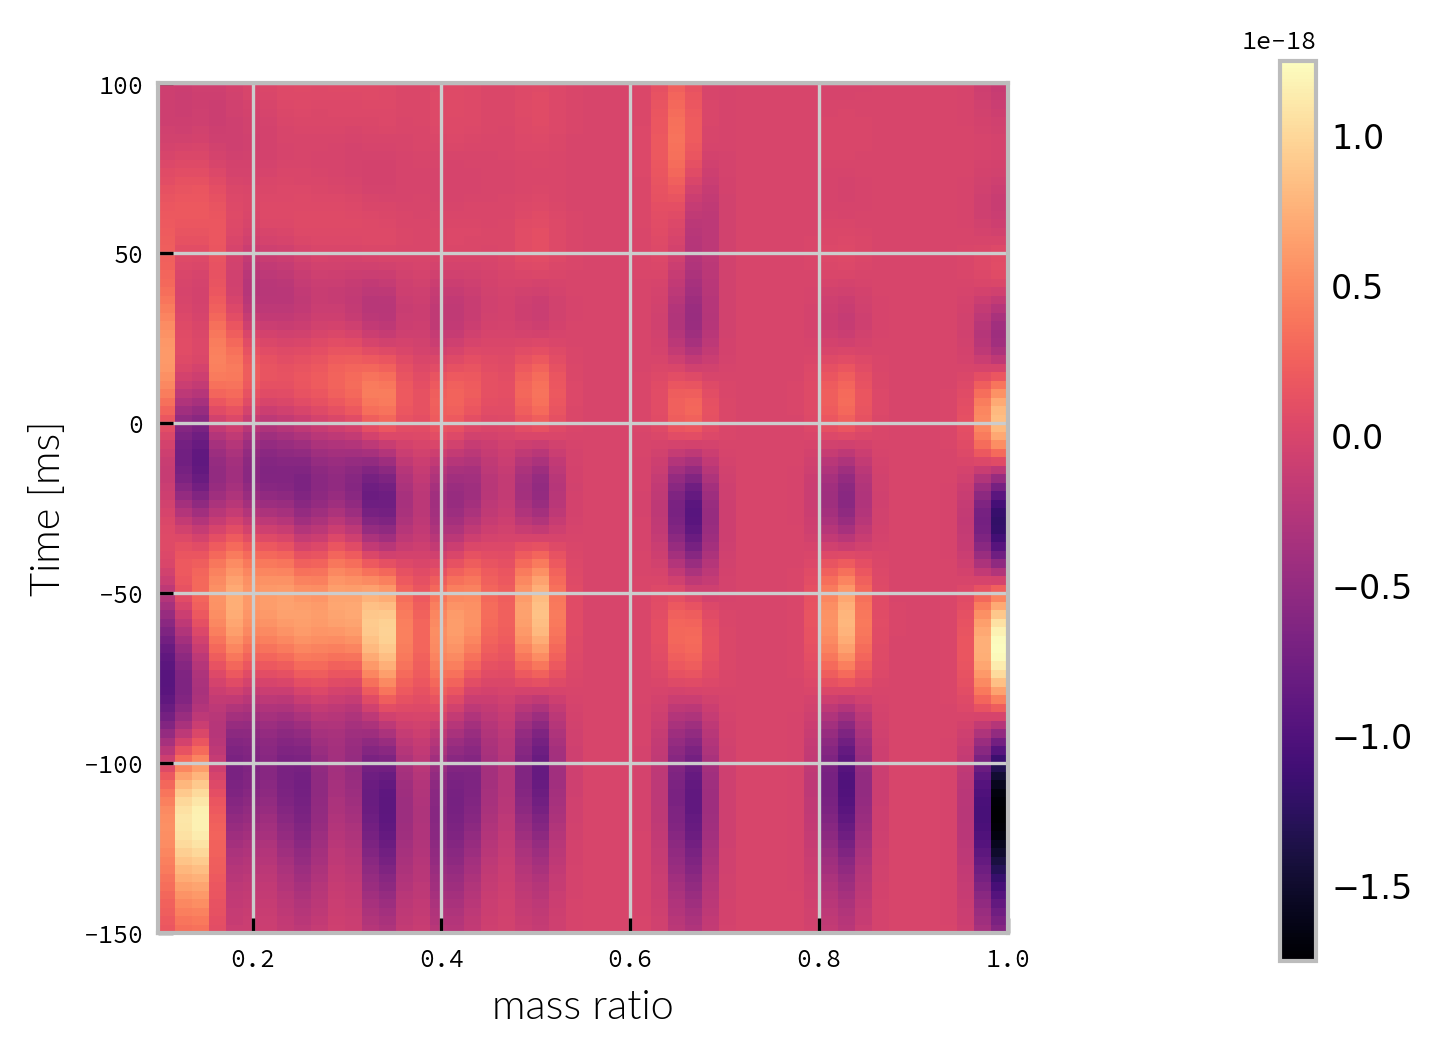

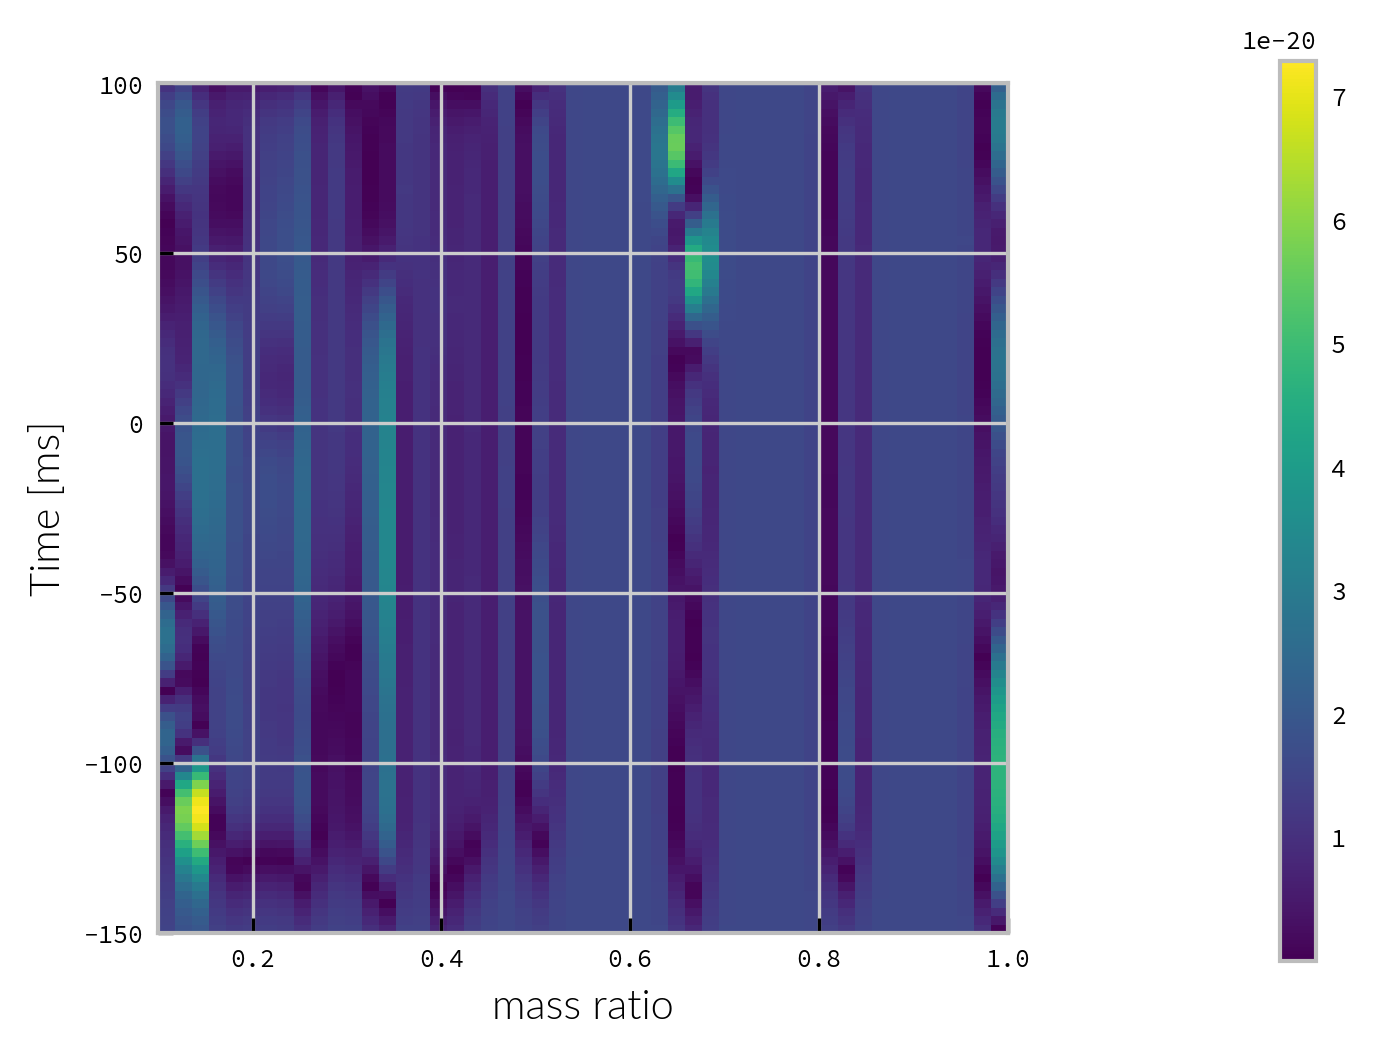

In [17]:
f, g = plot_planes(ranges={"time": [-150, 100, 100], "mass ratio": [0.1, 1.0, 50]}, fixed = {"spin 1x": 0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})

In [38]:
g.savefig("massratio-variance.pdf")